In [1]:
import argparse
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random 
import networkx as nx
import tensorflow as tf
import sklearn

from tensorflow import keras
from tqdm import tqdm
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from astropy import units as u
from astropy.coordinates import SkyCoord
from tensorflow.keras.utils import pad_sequences

from astroOracle.dataloader import LSSTSourceDataSet, load, get_augmented_data, get_static_features, ts_length, get_ts_upto_days_since_trigger, ts_flag_value, static_flag_value, augment_ts_length_to_days_since_trigger
from astroOracle.loss import WHXE_Loss
from astroOracle.taxonomy import get_taxonomy_tree, source_node_label
from astroOracle.vizualizations import make_gif, plot_reliability_diagram, plot_data_set_composition, plot_day_vs_class_score, plot_lc, make_z_plots
from astroOracle.interpret_results import get_conditional_probabilites, save_all_cf_and_rocs, save_leaf_cf_and_rocs, save_all_phase_vs_accuracy_plot
from astroOracle.train_RNN import default_batch_size
from astroOracle.LSST_Source import LSST_Source

In [3]:
# This step takes a while because it has load from disc to memory...
print("Loading testing data from disc...")
test_dir = Path("../processed/test")
X_ts = load(f"{test_dir}/x_ts.pkl")
X_static = load(f"{test_dir}/x_static.pkl")
Y = load(f"{test_dir}/y.pkl")
astrophysical_classes = load(f"{test_dir}/a_labels.pkl")

Loading testing data from disc...


In [4]:
X_ts[0]

,scaled_time_since_first_obs,detection_flag,scaled_FLUXCAL,scaled_FLUXCALERR,band_label
0,0.000000,0,-0.016419,0.014178,0.8700
1,0.000249,0,0.016658,0.030055,1.0150
2,0.049960,0,-0.012748,0.004795,0.6215
3,0.050392,0,0.000265,0.007020,0.7545
4,0.079403,0,-0.001897,0.002851,0.4760
...,...,...,...,...,...
363,8.677405,0,0.025315,0.019436,1.0150
364,8.717478,0,0.003752,0.004272,0.6215
365,8.717718,0,0.004470,0.002783,0.4760
366,8.717998,0,-0.004031,0.002925,0.4760


In [5]:
max_class_count = 2000
for i in tqdm(range(len(X_static))):        
    X_static[i] = get_static_features(X_static[i])

X_ts_balanced = []
X_static_balanced = []
Y_balanced = []
astrophysical_classes_balanced = []

# Fix random seed while generating LCs for figure 19
random.seed(42)

for c in np.unique(astrophysical_classes):

    idx = list(np.where(np.array(astrophysical_classes) == c)[0])
    
    if len(idx) > max_class_count:
        idx = random.sample(idx, max_class_count)

    X_ts_balanced += [X_ts[i] for i in idx]
    X_static_balanced += [X_static[i] for i in idx]
    Y_balanced += [Y[i] for i in idx]
    astrophysical_classes_balanced += [astrophysical_classes[i] for i in idx]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 463528/463528 [00:02<00:00, 221612.72it/s]


In [16]:
cm = plt.get_cmap('gist_rainbow')
NUM_COLORS = 20
color_arr=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

In [25]:
model = keras.models.load_model(f"../models/lsst_alpha_0.5_no_md/best_model.h5", compile=False)

In [26]:
tree = get_taxonomy_tree()
level_order_nodes = list(nx.bfs_tree(tree, source=source_node_label).nodes())

In [27]:
days = 2 ** np.array(range(11))
target_class = 'SLSN'

precision_arr = []
recall_arr = []

true_labels_arr = []
predicted_labels_arr = []

for d in days:

    print(f'Running inference for trigger + {d} days...')

    x1, x2, y_true, _ = augment_ts_length_to_days_since_trigger(X_ts_balanced, X_static_balanced, Y_balanced, astrophysical_classes_balanced, d)
    
    # Run inference on these
    y_pred = model.predict([x1, x2], batch_size=default_batch_size)

    # Get the conditional probabilities
    _, pseudo_conditional_probabilities = get_conditional_probabilites(y_pred, tree)

    leaf_nodes = np.array(level_order_nodes[-19:])

    predicted_class = np.argmax(pseudo_conditional_probabilities[:,-19:], axis=1)
    predicted_class = leaf_nodes[predicted_class]
    predicted_class = np.where(predicted_class==target_class, 1, 0)
    
    true_class = np.argmax(y_true[:,-19:], axis=1)
    true_class = leaf_nodes[true_class]
    true_class = np.where(true_class==target_class, 1, 0)

    true_labels_arr.append(true_class)
    predicted_labels_arr.append(predicted_class)
    
    p = sklearn.metrics.precision_score(true_class, predicted_class)
    r = sklearn.metrics.recall_score(true_class, predicted_class)

    precision_arr.append(p)
    recall_arr.append(r)

Running inference for trigger + 1 days...
36/36 [==============================] - 64s 2s/step
Running inference for trigger + 2 days...
36/36 [==============================] - 66s 2s/step
Running inference for trigger + 4 days...
36/36 [==============================] - 66s 2s/step
Running inference for trigger + 8 days...
36/36 [==============================] - 65s 2s/step
Running inference for trigger + 16 days...
36/36 [==============================] - 64s 2s/step
Running inference for trigger + 32 days...
36/36 [==============================] - 65s 2s/step
Running inference for trigger + 64 days...
36/36 [==============================] - 65s 2s/step
Running inference for trigger + 128 days...
36/36 [==============================] - 66s 2s/step
Running inference for trigger + 256 days...
36/36 [==============================] - 66s 2s/step
Running inference for trigger + 512 days...
36/36 [==============================] - 63s 2s/step
Running inference for trigger + 1024 days

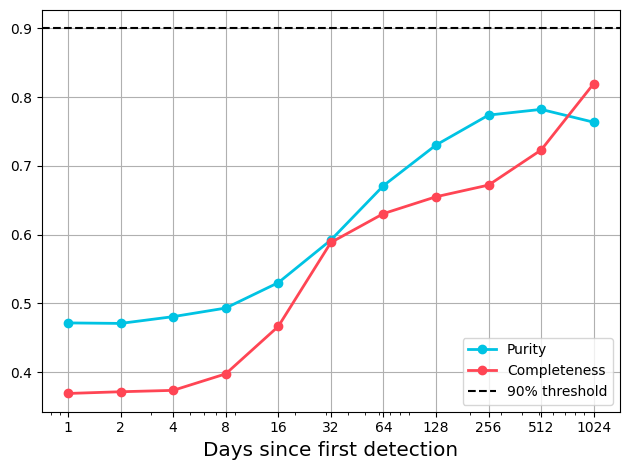

In [28]:
plt.style.use('default')
plt.plot(days, precision_arr, color='#00c3e3', marker='o', linewidth=2, label='Purity')
plt.plot(days, recall_arr, color='#ff4554', marker='o', linewidth=2, label='Completeness')

plt.axhline(0.9, color='black', linestyle='--', label='90% threshold')

plt.xlabel('Days since first detection', fontsize='x-large')

plt.legend()
plt.tight_layout()

plt.xscale('log')
plt.xticks(days, days)

plt.grid()

plt.savefig(f'../finesst_{target_class}_pc.pdf')

In [29]:
def plot_confusion_matrix(y_true, y_pred, labels, title=None, img_file=None):
    
    n_class = len(labels)
    font = {'size'   : 25}
    plt.rc('font', **font)
    
    cm = np.round(confusion_matrix(y_true, y_pred, labels=labels, normalize='true'),2)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    disp.im_.colorbar.remove()
    
    fig = disp.figure_

    plt.yticks(rotation=90)
    
    fig.set_figwidth(18)
    fig.set_figheight(18)
    
    for label in disp.text_.ravel():
        if n_class > 10:
            label.set_fontsize(12)
        elif n_class <= 10 and n_class > 3:
            disp.ax_.tick_params(axis='both', labelsize=40)
            label.set_fontsize('xx-large')
        else:
            disp.ax_.tick_params(axis='both', labelsize=40)
            label.set_fontsize('xx-large')

    disp.ax_.set_xlabel("Predicted Label", fontsize='xx-large')
    disp.ax_.set_ylabel("True Label", fontsize='xx-large')
    disp.ax_.set_title(title, fontsize=60)
    
    plt.tight_layout()

    if title:
        plt.title(title)

    if img_file:
        plt.savefig(img_file)

1024 days


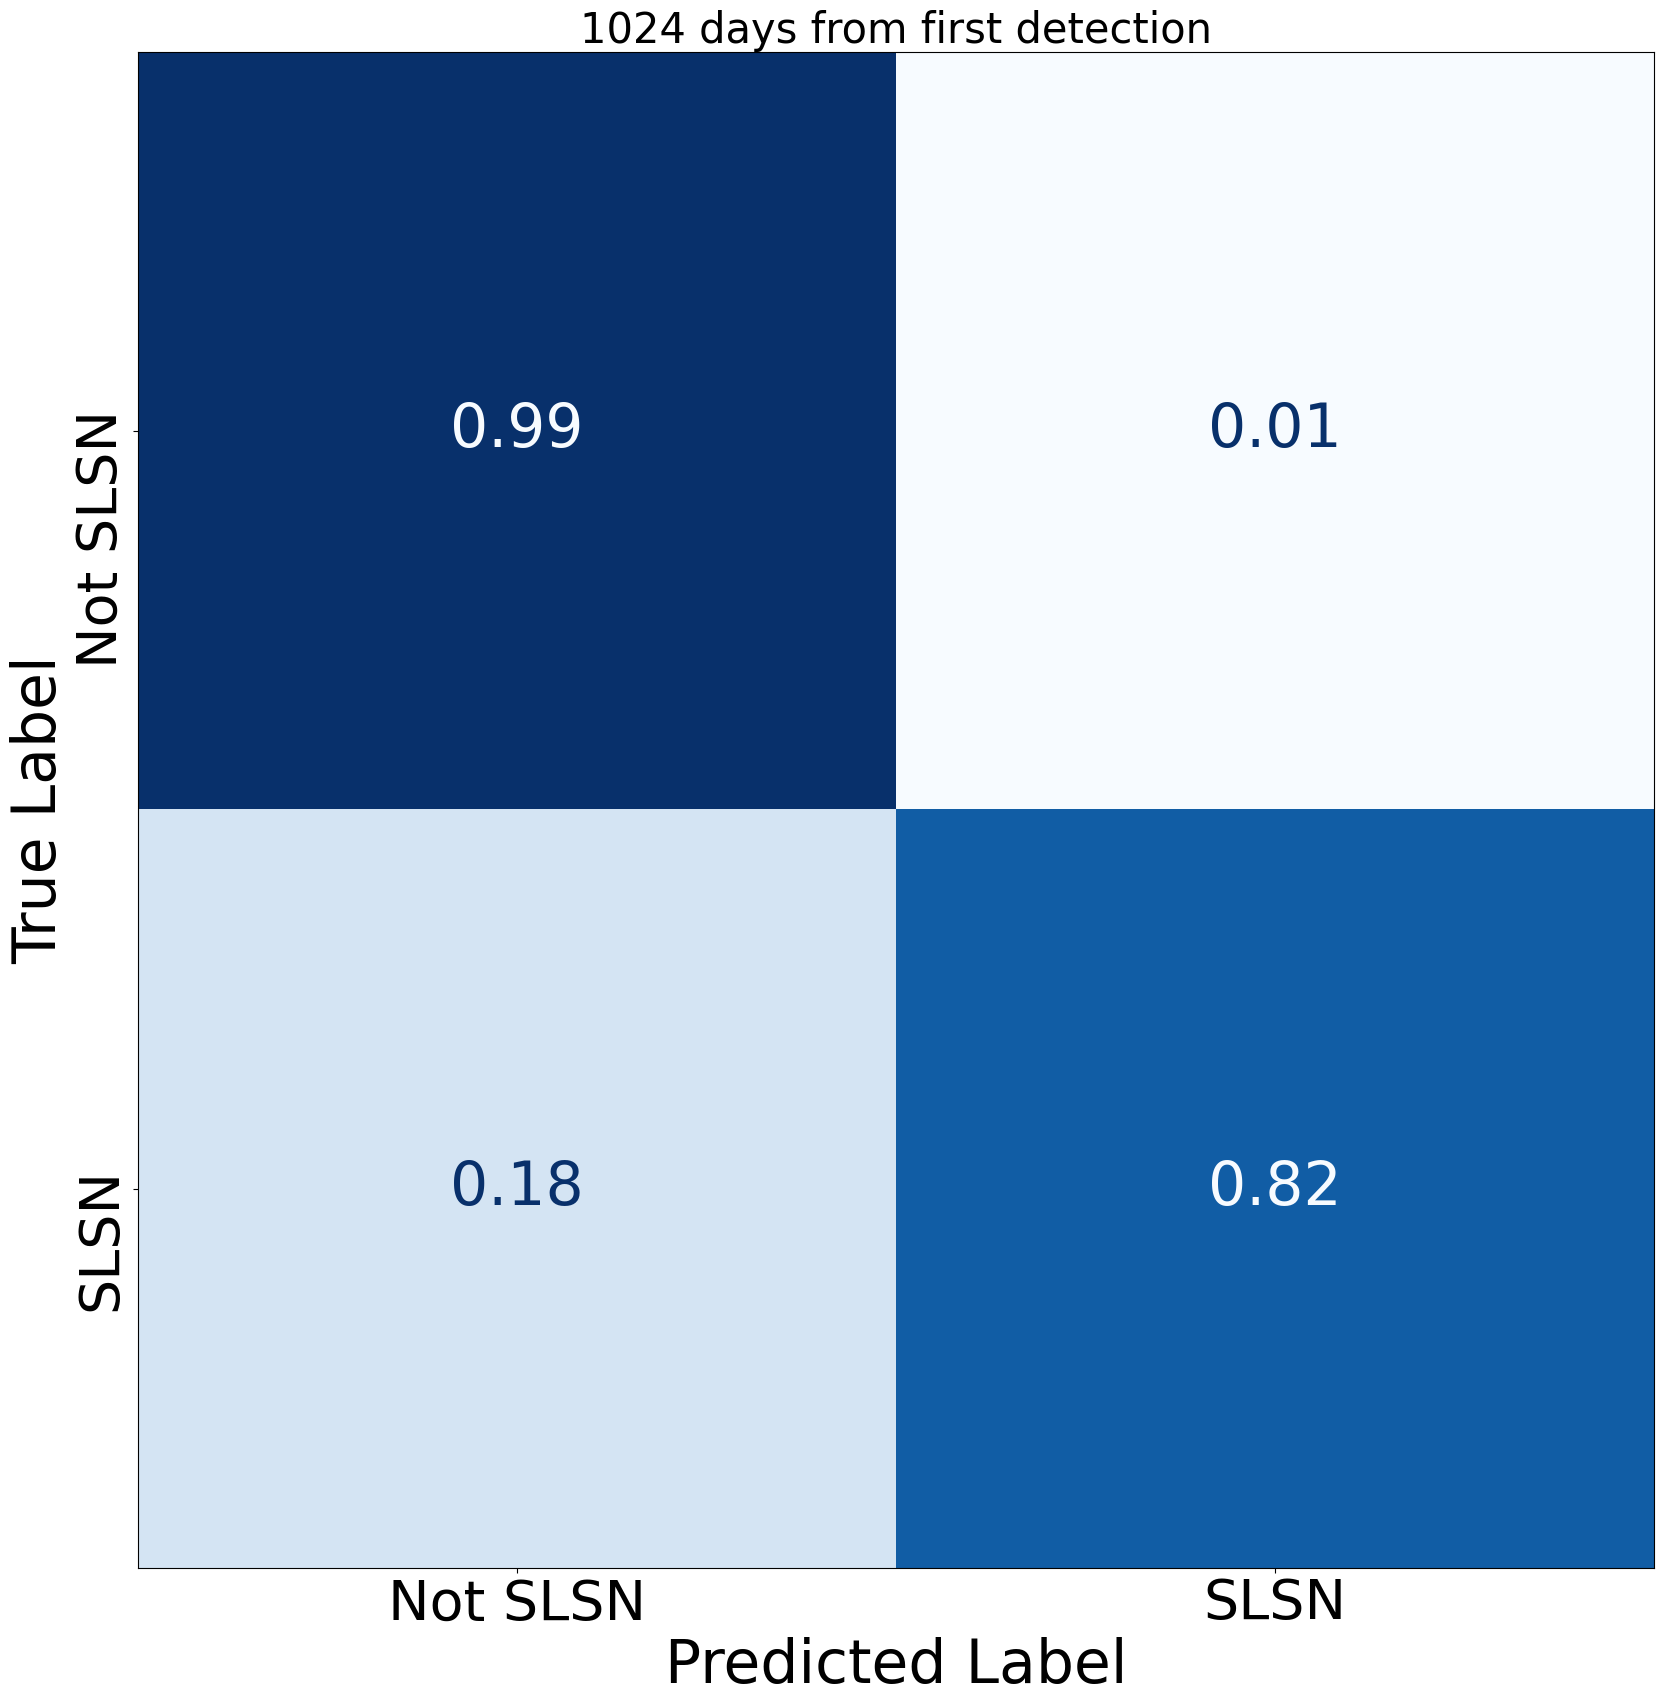

In [32]:
idx = 10
print(f"{days[idx]} days")
t, p = true_labels_arr[idx], predicted_labels_arr[idx]
t = np.where(t == 1, f'{target_class}', f'Not {target_class}')
p = np.where(p == 1, f'{target_class}', f'Not {target_class}')
plot_confusion_matrix(t, p, labels=[f'Not {target_class}', f'{target_class}'], img_file=f'finesst_day_{days[idx]}_cf.pdf', title=f"{days[idx]} days from first detection")

In [ ]:
precision_arr[idx], recall_arr[idx]